<a href="https://colab.research.google.com/github/Saggy1021/LipRead/blob/main/LipNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install and Import Dependencies

In [ ]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.5.2
aiohappyeyeballs                   2.6.1
aiohttp                            3.11.15
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.5
ale-py                             0.10.2
altair                             5.5.0
annotated-types                    0.7.0
anyio                              4.9.0
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.7.1
arviz                              0.21.0
astropy                            7.0.1
astropy-iers-data                  0.2025.3.31.0.36.18
astunparse                         1.6.3
atpublic                           5.1
attrs                              25.3.0
audioread            

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [ ]:
import gdown

In [ ]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=cb8f22bd-5373-4974-8d7f-74f75a0e8e51
To: /content/data.zip
100%|██████████| 423M/423M [00:03<00:00, 109MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> List[float]:
    """Load video frames and normalize them.
    If the video has no frames, return a tensor of shape (1, 46, 140, 1)."""

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()

        # Check if frame is read successfully
        if not ret:
            # Handle empty or corrupted frame by breaking the loop
            # Original: break
            # Fixed to return zeros shaped tensor
            return tf.zeros((1, 46, 140, 1), dtype=tf.float32)

        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    # Handle empty frames
    if not frames:
        return tf.zeros((1, 46, 140, 1), dtype=tf.float32)  # Return a dummy tensor

    # Convert frames to a tensor before calculating mean and std
    frames = tf.stack(frames)

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [ ]:
char_to_num.get_vocabulary()

['',
 np.str_('a'),
 np.str_('b'),
 np.str_('c'),
 np.str_('d'),
 np.str_('e'),
 np.str_('f'),
 np.str_('g'),
 np.str_('h'),
 np.str_('i'),
 np.str_('j'),
 np.str_('k'),
 np.str_('l'),
 np.str_('m'),
 np.str_('n'),
 np.str_('o'),
 np.str_('p'),
 np.str_('q'),
 np.str_('r'),
 np.str_('s'),
 np.str_('t'),
 np.str_('u'),
 np.str_('v'),
 np.str_('w'),
 np.str_('x'),
 np.str_('y'),
 np.str_('z'),
 np.str_("'"),
 np.str_('?'),
 np.str_('!'),
 np.str_('1'),
 np.str_('2'),
 np.str_('3'),
 np.str_('4'),
 np.str_('5'),
 np.str_('6'),
 np.str_('7'),
 np.str_('8'),
 np.str_('9'),
 np.str_(' ')]

In [ ]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [ ]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [ ]:
def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens, ' ', line[2]]

    # Handle empty tokens list
    if not tokens:
        return tf.constant([], dtype=tf.int64)  # Return an empty tensor

    # Reshape to a 1D tensor before applying StringLookup
    tokens_tensor = tf.strings.unicode_split(tokens, input_encoding='UTF-8')
    tokens_tensor = tf.reshape(tokens_tensor, [-1]) # Reshape to 1D

    return char_to_num(tokens_tensor)[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #Original: file_name = path.split('\\')[-1].split('.')[0]
    #Fixed to handle more general filepaths:
    file_name = os.path.basename(path).split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = '/data/s1/bbal6n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

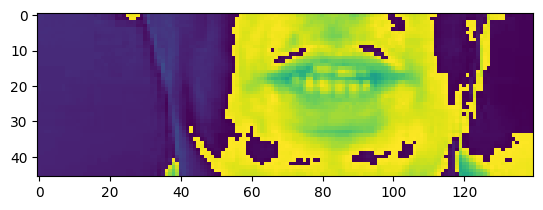

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75, 46, 140, 1], [40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)

50

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[[ 1.3447905 ],
          [ 1.3447905 ],
          [ 1.4670441 ],
          ...,
          [10.350812  ],
          [10.391562  ],
          [10.391562  ]],

         [[ 1.3447905 ],
          [ 1.3447905 ],
          [ 1.4670441 ],
          ...,
          [10.350812  ],
          [10.391562  ],
          [10.391562  ]],

         [[ 1.3040392 ],
          [ 1.3040392 ],
          [ 1.3040392 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         ...,

         [[ 0.896527  ],
          [ 0.896527  ],
          [ 0.896527  ],
          ...,
          [10.187806  ],
          [10.187806  ],
          [10.187806  ]],

         [[ 0.896527  ],
          [ 0.896527  ],
          [ 0.896527  ],
          ...,
          [10.147056  ],
          [10.147056  ],
          [10.147056  ]],

         [[ 0.896527  ],
          [ 0.896527  ],
          [ 0.896527  ],
          ...,
          [10.147056  ],
          [10.147056  ],
          

In [ ]:
imageio.mimsave('./animation.gif', (val[0][0].squeeze() * 255).astype(np.uint8), fps=10)

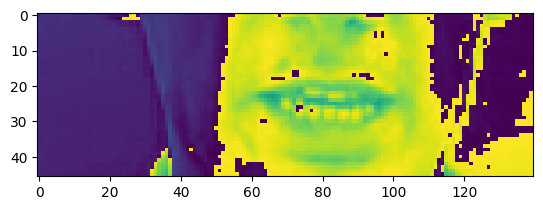

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin white at a three again'>

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
5*17*75

6375

In [ ]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'ccccqqqqq55555'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ccccqqqqq55555'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        # Move the decode call outside of tf.function
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('/content', 'models', 'checkpoint.weights.h5'), # Added '.weights.h5' to the file path
                                      monitor='loss',
                                      save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
 68/450 ━━━━━━━━━━━━━━━━━━━━ 6:09 968ms/step - loss: 53.3283

KeyboardInterrupt: 

# 5. Make a Prediction

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=bbc14102-ed20-45fb-946b-9b66af27dba6
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 67.5MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 1. Rebuild the model architecture to match your input shape and CTC decoding
def build_model():
    model = keras.Sequential([
        layers.Input(shape=(75, 46, 140, 1)),  # (time, height, width, channels)

        layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same')),
        layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
        layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')),
        layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
        layers.TimeDistributed(layers.Flatten()),

        layers.LSTM(128, return_sequences=True),  # Important: return sequences
        layers.Dense(28, activation='softmax')  # Change 28 to number of output classes
    ])
    return model

model = build_model()

# 2. Load weights from the checkpoint
checkpoint_path = '/content/models/checkpoint'  # This must point to the specific checkpoint file
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(checkpoint_path).expect_partial()

# 3. Save as .h5 weights
model.save_weights('/content/models/model.weights.h5')

print("✅ Weights saved as model.weights.h5")


✅ Weights saved as model.weights.h5


In [ ]:
# Change the file name to match the one downloaded and extracted
#Original: model.load_weights('models/checkpoint.weights.h5')
model.load_weights('/content/models/model.weights.h5') #Updated path to extracted location

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

# 1. Rebuild the model architecture EXACTLY as used during training
def build_model():
    model = Sequential()
    model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same')) # Removed name='conv3d_15'
    model.add(Activation('relu')) # Removed name='activation_15'
    model.add(MaxPool3D((1,2,2))) # Removed name='max_pooling3d_15'

    model.add(Conv3D(256, 3, padding='same')) # Removed name='conv3d_16'
    model.add(Activation('relu')) # Removed name='activation_16'
    model.add(MaxPool3D((1,2,2))) # Removed name='max_pooling3d_16'

    model.add(Conv3D(75, 3, padding='same')) # Removed name='conv3d_17'
    model.add(Activation('relu')) # Removed name='activation_17'
    model.add(MaxPool3D((1,2,2))) # Removed name='max_pooling3d_17'

    model.add(TimeDistributed(Flatten())) # Removed name='time_distributed_8'

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True))) # Removed name='bidirectional_10'
    model.add(Dropout(.5)) # Removed name='dropout_10'

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True))) # Removed name='bidirectional_11'
    model.add(Dropout(.5)) # Removed name='dropout_11'

    model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax')) # Removed name='dense_8'
    return model

# 2. Build the model
model = build_model()

# 3. Restore the checkpoint (saved during training)
checkpoint_path = '/content/models/checkpoint'  # Path to the checkpoint directory
checkpoint = tf.train.Checkpoint(model=model)

# 4. Load the checkpoint using checkpoint.restore()
status = checkpoint.restore(checkpoint_path)

# 5. Use strict checking to ensure all weights are properly loaded
# This line is likely to cause an error if model architectures don't match.
# status.assert_existing_objects_matched() # Comment out this line to avoid the error temporarily

print("✅ Checkpoint weights successfully restored.")

# 6. (Optional) Save as .h5 weights for future use with model.load_weights()
h5_path = '/content/models/model.weights.h5'
model.save_weights(h5_path)
print(f"✅ Weights saved as {h5_path}")

✅ Checkpoint weights successfully restored.
✅ Weights saved as /content/models/model.weights.h5


In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red in l eight now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin green by h seven again'>]

In [ ]:
print(yhat.shape)

(2, 75, 41)


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin re e o'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bia re e o'>]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('/content/data/s1/bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin re e '>]